In [1]:
import argparse
import os
import time
import torch
import numpy as np
from tqdm import tqdm
from scipy.signal import butter, filtfilt

from BioMime.utils.basics import update_config, load_generator
from BioMime.utils.plot_functions import plot_muaps
from BioMime.utils.params import num_mus, steps, tgt_params
from BioMime.models.generator import Generator

from models import ConditionBiomime


In [2]:
from biomime_generator import *

In [3]:
device = 'cuda:0'
config_path = './config/config.yaml'
model_checkpoint = './ckp/model_linear.pth'
biomime_gen = BiomimeMuapGenerator(config_path=config_path, model_checkpoint=model_checkpoint, device=device)


In [4]:
class ConditionOptimizer1(nn.Module):
    def __init__(
        self, 
        biomime, 
        initial_input, 
        indices=[0,1,2,3,4,5], 
        margin=1.2,
        device='cuda:0'
    ):
        super(ConditionOptimizer1, self).__init__()
        self.device = device
        self.biomime_muap_gen = biomime.to(device)  # Pretrained BioMime network

        self.indices = indices
        self.margin = margin

        # Make the portion of input that is learnable an nn.Parameter
        # We use logit of the initial_input so we can pass it through a sigmoid
        # self.opt_params = nn.Parameter(
        #     torch.logit(initial_input.clone().detach()[:, indices] / self.margin)
        # )
        self.opt_params = nn.Parameter(
            (initial_input.clone().detach()[:, indices] / self.margin)
        )

        # The rest of the input, which remains fixed, also store in self
        # but *not* as a parameter
        self.biomime_input = (initial_input.clone().detach().to(device))

        # Some additional parameter or condition (zi)

        # Sigmoid to map logits -> [0, 1] range
        self.sig = nn.Sigmoid()

    def forward(self, n_mus):
        """
        Forward pass: 
        1. Copies biomime_input
        2. Replaces specified indices with self.opt_params (learnable)
        3. Calls self.biomime.sample(...) to generate waveforms
        """
        biomime_input = self.biomime_input.clone()
        biomime_input[:, self.indices] = self.opt_params  # replace the chosen indices

        # We assume biomime.sample(...) returns waveforms or MUAPs
        # Make sure you pass the *sigmoid* of biomime_input if your model expects values in [0,1]
        output = self.biomime_muap_gen((biomime_input)* self.margin)
        return output

    def get_conditions(self):
        """
        Return the current conditions (i.e., the parameters in [0, 1]).
        This can be used to check the learned values after optimization.
        """
        return (self.opt_params) * self.margin

In [5]:
import torch
import numpy as np
from emg_processor import EMGProcessor

class EMGDataset:
    def __init__(self, file_path):
        """
        Load dataset from an .npz file, including zi (Gaussian-related variable).
        """
        if not file_path.endswith(".npz"):
            raise ValueError("Only .npz file format is supported.")
        
        data = np.load(file_path)
        self.data_dict = {key: data[key] for key in data.files}
        self.tensors = {}

    def to_torch(self):
        """
        Convert all loaded numpy arrays into PyTorch tensors.
        """
        self.tensors = {key: torch.tensor(value, dtype=torch.float32) for key, value in self.data_dict.items()}

    def get_tensor(self, name):
        """
        Retrieve a specific tensor by name.
        """
        if name in self.tensors:
            return self.tensors[name]
        else:
            raise ValueError(f"Tensor '{name}' not found. Ensure you have called to_torch() first.")


    def add_noise(self, noise_std=0.1):
        self.data_dict["emg"] += np.random.rand(*self.data_dict["emg"].shape) * noise_std
        
        # # update rect of the vectors
        R = emg_data.data_dict['extended_emg'].shape[1] - emg_data.data_dict['emg'].shape[1] + 1
        self.data_dict['extended_emg']  = EMGProcessor.extend_emg(emg_data.data_dict['emg'], R)
        self.data_dict['covariance_matrix'] = EMGProcessor.get_inv_cov(self.data_dict['extended_emg'] , explained_var=1e-14)

    def to_device(self, device='cpu'):
        """
        Move tensors to GPU/CPU.
        """
        self.tensors = {key: tensor.to(device) for key, tensor in self.tensors.items()}

# Example usage
emg_data = EMGDataset("emg_data_10s_100MUs.npz")  # Load the dataset
emg_data.to_torch()  # Convert to torch tensors
emg_data.to_device('cuda')  # Move to GPU if needed

# Retrieve tensors (including zi)
tensor_emg = emg_data.get_tensor("emg")
tensor_zi = emg_data.get_tensor("zi")

print(tensor_emg.shape)  # Check shape
print(tensor_zi.shape)  # Ensure zi is correctly loaded


torch.Size([320, 20000])
torch.Size([1, 16])


In [9]:
np.mean(emg_data.data_dict['emg'][0] ** 2) / 0.025

5.321070324383868

In [44]:
emg_data.add_noise(noise_std=0.1)  # Add noise to EMG data

Extending EMG: 100%|██████████| 10/10 [00:00<00:00, 94.48it/s]


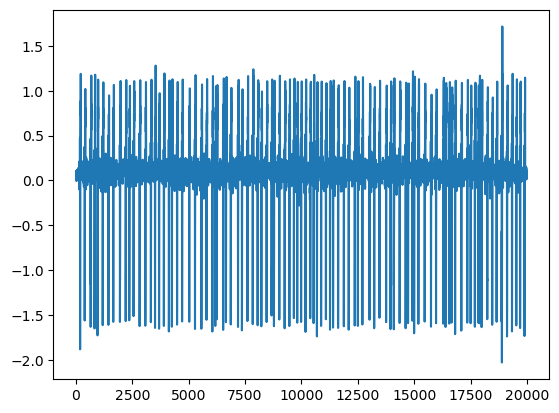

In [45]:
import matplotlib.pyplot as plt
plt.plot(emg_data.data_dict['emg'][0])

In [11]:
emg_data.data_dict['extended_emg'].shape
emg_data.data_dict['covariance_matrix'].shape

(3200, 3200)

In [12]:
device = 'cuda:0'
config_path = './config/config.yaml'
model_checkpoint = './ckp/model_linear.pth'
biomime_gen = BiomimeMuapGenerator(config_path=config_path, zi=emg_data.tensors['zi'].to(torch.float32), model_checkpoint=model_checkpoint, device=device)


In [13]:
n_mus_search = 20
emg_data.tensors['base_conditions'][:n_mus_search]

tensor([[1.0000, 0.7184, 0.1640, 0.7129, 0.8192, 0.4706],
        [0.3332, 0.4224, 0.9559, 0.7592, 0.5878, 0.5689],
        [0.2627, 0.4929, 0.6966, 0.6948, 0.7955, 0.0088],
        [0.2350, 0.2839, 0.5928, 0.8198, 0.2333, 0.1558],
        [0.2008, 0.0901, 0.6706, 0.9363, 0.8569, 0.6163],
        [0.1848, 0.8508, 0.1729, 0.4724, 0.9697, 0.9890],
        [0.1688, 0.3712, 0.2514, 0.1978, 0.5985, 0.5604],
        [0.0959, 0.6399, 0.4732, 0.5682, 0.8930, 0.2446],
        [0.0810, 0.8748, 0.2321, 0.3105, 0.0054, 0.7673],
        [0.0789, 0.6725, 0.0795, 0.8166, 0.0512, 0.6976],
        [0.0768, 0.0449, 0.1783, 0.0874, 0.1510, 0.4269],
        [0.0739, 0.2149, 0.1889, 0.3256, 0.1972, 0.1378],
        [0.0727, 0.7045, 0.1624, 0.6724, 0.5816, 0.7886],
        [0.0695, 0.4287, 0.6674, 0.0533, 0.7448, 0.3267],
        [0.0691, 0.9405, 0.6607, 0.1700, 0.8169, 0.3631],
        [0.0686, 0.5176, 0.2591, 0.3035, 0.2559, 0.8594],
        [0.0674, 0.3586, 0.6748, 0.9895, 0.7878, 0.1993],
        [0.066

In [27]:
from scipy.stats import qmc  # For Latin Hypercube Sampling

from time import time
batch_size = 30
total_reps = 10
probe_points = probe_points

all_muaps = []
all_conds = []


for k in range(total_reps):
    st = time()

    torch.cuda.empty_cache()

    lhs_sampler = qmc.LatinHypercube(d=6)
        
    result = torch.tensor(qmc.scale(lhs_sampler.random(10000), 0, 1), dtype=torch.float32, device='cpu')
    result.shape

    torch.cuda.empty_cache()
    bsize = 100
    total = probe_points
    result_batched = result.reshape(-1, bsize, 6)
    all_res = []
    for i in tqdm(range(result_batched.shape[0])):
        all_res.append(biomime_gen(torch.tensor(result_batched[i]).cuda()).detach())


    from emg_processor import EMGProcessor
    hmap = torch.stack(all_res)
    hmap = hmap.reshape(probe_points, 96, 10, 32)
    hmap = hmap.reshape(probe_points, 96, 320).permute(0, 2, 1).to(torch.float32)
    training_data = emg_data.tensors['extended_emg'].to(device)
    cov = emg_data.tensors['covariance_matrix'].to(device)
    R = 10
    filters = EMGProcessor.get_separation_vectors_torch(hmap, R=R)
    mu1 = filters.T @  cov @ training_data
    mu1.shape

    from models import *

    loss = -torch_kurtosis(mu1)
    loss_sorted = loss.sort()
    idx = loss_sorted.indices[:20]
    start_conds = result[idx.detach().cpu().numpy()]

    torch.cuda.empty_cache()

    import torch
    import torch.optim as optim
    from models import *
    from emg_processor import *

    # -----------
    # HYPOTHETICAL EXTERNALS 
    # -----------
    # biomime:         your pretrained BioMime model
    # initial_input:   some initial (batch_size x n_features) Tensor, in [0,1]
    # zi:              additional condition for biomime.sample
    # R, whitening_tensor, n_mus, training_data: placeholder references to your data
    # get_separation_vectors: you must ensure this function is PyTorch-friendly
    # -----------
    # Suppose we have:

    device = 'cuda:0'
    n_mus_search = batch_size  # number of motor units or waveforms to sample, for example
    #
    #
    #initial_cond = emg_data.tensors['base_conditions'][:n_mus_search]# + torch.rand(n_mus_search, 6).cuda() * 0.1
    initial_cond = start_conds #torch.rand(n_mus_search, 6)
    # initial_cond[:, 0] = torch.rand(n_mus_search).to(device)
    # initial_cond[:, 2] = torch.rand(n_mus_search).to(device)

    #torch.tensor([[0.2535, 0.6657, 0.3464, 0.9506, 0.8990, 0.0827]])

    # Create ConditionOptimizer
    model = ConditionOptimizer1(
        biomime=biomime_gen,
        initial_input=initial_cond.clone().to(torch.float32).detach(),
        indices=[0,1,2,3,4,5],  # e.g. just 2 learnable parameters
        margin=1.0,
        device=device
    ).to(device)

    # Create an optimizer on the model's parameters
    #optimizer = optim.Adam([model.opt_params], lr=1e-2)
    optimizer = optim.Adam([model.opt_params], lr=1e-3)

    # Transfer everything needed to device

    kurt_per_mu_last = torch.zeros(n_mus_search, device=device)
    print(f"probe phase time: {time()- st}")

    kurt_per_mu_all = []
    # Training loop
    num_epochs = 250
    for epoch in range(num_epochs):
        # 1) Zero out gradients
        optimizer.zero_grad()

        # 2) Forward pass through ConditionOptimizer => BioMime => MUAP waveforms
        muaps = model.forward(n_mus_search)   # shape e.g. [n_mus, ...whatever shape...]
        muaps = muaps.reshape(n_mus_search, 96, 320).permute(0, 2, 1).to(torch.float32)
        # Suppose shape is (n_mus, 96, 320), as in your example:
        # muaps = muaps.reshape(n_mus, 96, 320).permute(0, 2, 1)

        # 3) Construct filters in Torch
        # get_separation_vectors should be a PyTorch function 
        # returning a torch.Tensor that maintains gradient if needed
        filters = EMGProcessor.get_separation_vectors_torch(muaps, R=R)
        
        mu1 = filters.T @  cov @ training_data

        # mu1 is now [time_points]

        # 6) Compute kurtosis
        kurt_per_mu = -torch_kurtosis(mu1)#negen_loss(mu1)
        #kurt_per_mu = negen_loss(mu1)
        kurt = kurt_per_mu.sum()  # This is a PyTorch Tensor


        # 7) Define loss
        # If you want to maximize kurtosis, you can do loss = -kurt
        loss = kurt
        # 8) Backprop
        

        loss.backward()


        # 9) Update
        optimizer.step()
        kurt_per_mu_all.append(kurt_per_mu.detach().cpu().numpy())

        # if (epoch+1) % 20 == 0:
        #     with torch.no_grad():
        #         #mask = ((kurt_per_mu - kurt_per_mu_last)/kurt_per_mu_last < 3.0) & (kurt_per_mu < 10)
        #         mask = kurt_per_mu < 0
        #         indices = torch.where(mask)[0]
        #         print(len(indices))
        #         #print(indices)
        #         kurt_per_mu_last = kurt_per_mu
        #         for index in indices:
        #             model.opt_params[index] = torch.rand(6)
        #             kurt_per_mu[index] = 0.
                


        # 10) (Optional) Print or log stats
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.6f} - Kurt: {kurt.item():.6f}")
            #print("Current conditions:", model.get_conditions()[0].data.cpu().numpy())

    all_conds.append(model.get_conditions().detach().cpu().numpy())
    all_muaps.append(model.forward(n_mus_search).detach().cpu().numpy())

    print(time()- st)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_208808/3978094493.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_res.append(biomime_gen(torch.tensor(result_batched[i]).cuda()).detach())
100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


probe phase time: 15.672526121139526
Epoch [10/250] - Loss: -2.327997 - Kurt: -2.327997
Epoch [20/250] - Loss: -3.492728 - Kurt: -3.492728
Epoch [30/250] - Loss: -4.591246 - Kurt: -4.591246
Epoch [40/250] - Loss: -5.658033 - Kurt: -5.658033
Epoch [50/250] - Loss: -6.556281 - Kurt: -6.556281
Epoch [60/250] - Loss: -7.200744 - Kurt: -7.200744
Epoch [70/250] - Loss: -7.807421 - Kurt: -7.807421
Epoch [80/250] - Loss: -8.346292 - Kurt: -8.346292
Epoch [90/250] - Loss: -8.780899 - Kurt: -8.780899
Epoch [100/250] - Loss: -9.182056 - Kurt: -9.182056
Epoch [110/250] - Loss: -9.569611 - Kurt: -9.569611
Epoch [120/250] - Loss: -9.909573 - Kurt: -9.909573
Epoch [130/250] - Loss: -10.178850 - Kurt: -10.178850
Epoch [140/250] - Loss: -10.367787 - Kurt: -10.367787
Epoch [150/250] - Loss: -10.491687 - Kurt: -10.491687
Epoch [160/250] - Loss: -10.586325 - Kurt: -10.586325
Epoch [170/250] - Loss: -10.666463 - Kurt: -10.666463
Epoch [180/250] - Loss: -10.735580 - Kurt: -10.735580
Epoch [190/250] - Loss: 

100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


probe phase time: 18.972348928451538
Epoch [10/250] - Loss: -1.715160 - Kurt: -1.715160
Epoch [20/250] - Loss: -2.672942 - Kurt: -2.672942
Epoch [30/250] - Loss: -3.330490 - Kurt: -3.330490
Epoch [40/250] - Loss: -4.028806 - Kurt: -4.028806
Epoch [50/250] - Loss: -4.532808 - Kurt: -4.532808
Epoch [60/250] - Loss: -5.033032 - Kurt: -5.033032
Epoch [70/250] - Loss: -5.462648 - Kurt: -5.462648
Epoch [80/250] - Loss: -5.813668 - Kurt: -5.813668
Epoch [90/250] - Loss: -6.032548 - Kurt: -6.032548
Epoch [100/250] - Loss: -6.198112 - Kurt: -6.198112
Epoch [110/250] - Loss: -6.366530 - Kurt: -6.366530
Epoch [120/250] - Loss: -6.527997 - Kurt: -6.527997
Epoch [130/250] - Loss: -6.675103 - Kurt: -6.675103
Epoch [140/250] - Loss: -6.822705 - Kurt: -6.822705
Epoch [150/250] - Loss: -6.978391 - Kurt: -6.978391
Epoch [160/250] - Loss: -7.136242 - Kurt: -7.136242
Epoch [170/250] - Loss: -7.290667 - Kurt: -7.290667
Epoch [180/250] - Loss: -7.434869 - Kurt: -7.434869
Epoch [190/250] - Loss: -7.559278 - 

100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


probe phase time: 19.986145973205566
Epoch [10/250] - Loss: -1.226660 - Kurt: -1.226660
Epoch [20/250] - Loss: -1.993254 - Kurt: -1.993254
Epoch [30/250] - Loss: -2.937418 - Kurt: -2.937418
Epoch [40/250] - Loss: -3.984758 - Kurt: -3.984758
Epoch [50/250] - Loss: -4.738760 - Kurt: -4.738760
Epoch [60/250] - Loss: -5.428819 - Kurt: -5.428819
Epoch [70/250] - Loss: -6.025553 - Kurt: -6.025553
Epoch [80/250] - Loss: -6.512676 - Kurt: -6.512676
Epoch [90/250] - Loss: -6.961393 - Kurt: -6.961393
Epoch [100/250] - Loss: -7.348122 - Kurt: -7.348122
Epoch [110/250] - Loss: -7.699555 - Kurt: -7.699555
Epoch [120/250] - Loss: -8.065022 - Kurt: -8.065022
Epoch [130/250] - Loss: -8.432812 - Kurt: -8.432812
Epoch [140/250] - Loss: -8.782795 - Kurt: -8.782795
Epoch [150/250] - Loss: -9.101610 - Kurt: -9.101610
Epoch [160/250] - Loss: -9.406295 - Kurt: -9.406295
Epoch [170/250] - Loss: -9.683039 - Kurt: -9.683039
Epoch [180/250] - Loss: -9.934134 - Kurt: -9.934134
Epoch [190/250] - Loss: -10.154694 -

100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


probe phase time: 20.567051649093628
Epoch [10/250] - Loss: -1.210109 - Kurt: -1.210109
Epoch [20/250] - Loss: -1.799342 - Kurt: -1.799342
Epoch [30/250] - Loss: -2.436500 - Kurt: -2.436500
Epoch [40/250] - Loss: -3.100939 - Kurt: -3.100939
Epoch [50/250] - Loss: -3.832313 - Kurt: -3.832313
Epoch [60/250] - Loss: -4.614609 - Kurt: -4.614609
Epoch [70/250] - Loss: -5.411300 - Kurt: -5.411300
Epoch [80/250] - Loss: -6.113173 - Kurt: -6.113173
Epoch [90/250] - Loss: -6.713172 - Kurt: -6.713172
Epoch [100/250] - Loss: -7.295037 - Kurt: -7.295037
Epoch [110/250] - Loss: -7.823812 - Kurt: -7.823812
Epoch [120/250] - Loss: -8.341787 - Kurt: -8.341787
Epoch [130/250] - Loss: -8.837223 - Kurt: -8.837223
Epoch [140/250] - Loss: -9.269315 - Kurt: -9.269315
Epoch [150/250] - Loss: -9.623108 - Kurt: -9.623108
Epoch [160/250] - Loss: -9.895548 - Kurt: -9.895548
Epoch [170/250] - Loss: -10.110170 - Kurt: -10.110170
Epoch [180/250] - Loss: -10.301876 - Kurt: -10.301876
Epoch [190/250] - Loss: -10.4845

100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


probe phase time: 20.802523136138916
Epoch [10/250] - Loss: -1.620550 - Kurt: -1.620550
Epoch [20/250] - Loss: -2.698308 - Kurt: -2.698308
Epoch [30/250] - Loss: -3.596620 - Kurt: -3.596620
Epoch [40/250] - Loss: -4.492442 - Kurt: -4.492442
Epoch [50/250] - Loss: -5.384595 - Kurt: -5.384595
Epoch [60/250] - Loss: -6.138686 - Kurt: -6.138686
Epoch [70/250] - Loss: -6.717417 - Kurt: -6.717417
Epoch [80/250] - Loss: -7.201886 - Kurt: -7.201886
Epoch [90/250] - Loss: -7.580068 - Kurt: -7.580068
Epoch [100/250] - Loss: -7.858318 - Kurt: -7.858318
Epoch [110/250] - Loss: -8.100885 - Kurt: -8.100885
Epoch [120/250] - Loss: -8.323712 - Kurt: -8.323712
Epoch [130/250] - Loss: -8.521803 - Kurt: -8.521803
Epoch [140/250] - Loss: -8.693064 - Kurt: -8.693064
Epoch [150/250] - Loss: -8.844072 - Kurt: -8.844072
Epoch [160/250] - Loss: -8.980324 - Kurt: -8.980324
Epoch [170/250] - Loss: -9.101118 - Kurt: -9.101118
Epoch [180/250] - Loss: -9.208878 - Kurt: -9.208878
Epoch [190/250] - Loss: -9.306911 - 

100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


probe phase time: 20.909624814987183
Epoch [10/250] - Loss: -1.405781 - Kurt: -1.405781
Epoch [20/250] - Loss: -2.356509 - Kurt: -2.356509
Epoch [30/250] - Loss: -3.133148 - Kurt: -3.133148
Epoch [40/250] - Loss: -3.835643 - Kurt: -3.835643
Epoch [50/250] - Loss: -4.660216 - Kurt: -4.660216
Epoch [60/250] - Loss: -5.400478 - Kurt: -5.400478
Epoch [70/250] - Loss: -6.067702 - Kurt: -6.067702
Epoch [80/250] - Loss: -6.585836 - Kurt: -6.585836
Epoch [90/250] - Loss: -7.032177 - Kurt: -7.032177
Epoch [100/250] - Loss: -7.420557 - Kurt: -7.420557
Epoch [110/250] - Loss: -7.760966 - Kurt: -7.760966
Epoch [120/250] - Loss: -8.038734 - Kurt: -8.038734
Epoch [130/250] - Loss: -8.276682 - Kurt: -8.276682
Epoch [140/250] - Loss: -8.486132 - Kurt: -8.486132
Epoch [150/250] - Loss: -8.666912 - Kurt: -8.666912
Epoch [160/250] - Loss: -8.819189 - Kurt: -8.819189
Epoch [170/250] - Loss: -8.956594 - Kurt: -8.956594
Epoch [180/250] - Loss: -9.075096 - Kurt: -9.075096
Epoch [190/250] - Loss: -9.184082 - 

100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


probe phase time: 21.06388020515442
Epoch [10/250] - Loss: -1.290786 - Kurt: -1.290786
Epoch [20/250] - Loss: -2.201723 - Kurt: -2.201723
Epoch [30/250] - Loss: -3.057435 - Kurt: -3.057435
Epoch [40/250] - Loss: -3.884575 - Kurt: -3.884575
Epoch [50/250] - Loss: -4.733360 - Kurt: -4.733360
Epoch [60/250] - Loss: -5.464708 - Kurt: -5.464708
Epoch [70/250] - Loss: -6.160993 - Kurt: -6.160993
Epoch [80/250] - Loss: -6.796592 - Kurt: -6.796592
Epoch [90/250] - Loss: -7.319496 - Kurt: -7.319496
Epoch [100/250] - Loss: -7.786360 - Kurt: -7.786360
Epoch [110/250] - Loss: -8.212557 - Kurt: -8.212557
Epoch [120/250] - Loss: -8.646349 - Kurt: -8.646349
Epoch [130/250] - Loss: -9.054574 - Kurt: -9.054574
Epoch [140/250] - Loss: -9.446537 - Kurt: -9.446537
Epoch [150/250] - Loss: -9.781412 - Kurt: -9.781412
Epoch [160/250] - Loss: -10.031528 - Kurt: -10.031528
Epoch [170/250] - Loss: -10.202687 - Kurt: -10.202687
Epoch [180/250] - Loss: -10.338769 - Kurt: -10.338769
Epoch [190/250] - Loss: -10.451

100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


probe phase time: 20.935533046722412
Epoch [10/250] - Loss: -1.444309 - Kurt: -1.444309
Epoch [20/250] - Loss: -2.447392 - Kurt: -2.447392
Epoch [30/250] - Loss: -3.380140 - Kurt: -3.380140
Epoch [40/250] - Loss: -4.148463 - Kurt: -4.148463
Epoch [50/250] - Loss: -4.844863 - Kurt: -4.844863
Epoch [60/250] - Loss: -5.585505 - Kurt: -5.585505
Epoch [70/250] - Loss: -6.284003 - Kurt: -6.284003
Epoch [80/250] - Loss: -6.931999 - Kurt: -6.931999
Epoch [90/250] - Loss: -7.484735 - Kurt: -7.484735
Epoch [100/250] - Loss: -8.007957 - Kurt: -8.007957
Epoch [110/250] - Loss: -8.538920 - Kurt: -8.538920
Epoch [120/250] - Loss: -8.995735 - Kurt: -8.995735
Epoch [130/250] - Loss: -9.298542 - Kurt: -9.298542
Epoch [140/250] - Loss: -9.597713 - Kurt: -9.597713
Epoch [150/250] - Loss: -9.901551 - Kurt: -9.901551
Epoch [160/250] - Loss: -10.168020 - Kurt: -10.168020
Epoch [170/250] - Loss: -10.400434 - Kurt: -10.400434
Epoch [180/250] - Loss: -10.583384 - Kurt: -10.583384
Epoch [190/250] - Loss: -10.72

100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


probe phase time: 20.73543357849121
Epoch [10/250] - Loss: -1.236707 - Kurt: -1.236707
Epoch [20/250] - Loss: -1.929675 - Kurt: -1.929675
Epoch [30/250] - Loss: -2.696371 - Kurt: -2.696371
Epoch [40/250] - Loss: -3.634830 - Kurt: -3.634830
Epoch [50/250] - Loss: -4.540767 - Kurt: -4.540767
Epoch [60/250] - Loss: -5.424708 - Kurt: -5.424708
Epoch [70/250] - Loss: -6.255370 - Kurt: -6.255370
Epoch [80/250] - Loss: -7.019432 - Kurt: -7.019432
Epoch [90/250] - Loss: -7.710186 - Kurt: -7.710186
Epoch [100/250] - Loss: -8.369838 - Kurt: -8.369838
Epoch [110/250] - Loss: -8.902227 - Kurt: -8.902227
Epoch [120/250] - Loss: -9.291639 - Kurt: -9.291639
Epoch [130/250] - Loss: -9.578501 - Kurt: -9.578501
Epoch [140/250] - Loss: -9.796585 - Kurt: -9.796585
Epoch [150/250] - Loss: -9.960686 - Kurt: -9.960686
Epoch [160/250] - Loss: -10.088547 - Kurt: -10.088547
Epoch [170/250] - Loss: -10.178844 - Kurt: -10.178844
Epoch [180/250] - Loss: -10.245422 - Kurt: -10.245422
Epoch [190/250] - Loss: -10.299

100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


probe phase time: 20.94126558303833
Epoch [10/250] - Loss: -1.070893 - Kurt: -1.070893
Epoch [20/250] - Loss: -1.973646 - Kurt: -1.973646
Epoch [30/250] - Loss: -2.920049 - Kurt: -2.920049
Epoch [40/250] - Loss: -4.016644 - Kurt: -4.016644
Epoch [50/250] - Loss: -4.769740 - Kurt: -4.769740
Epoch [60/250] - Loss: -5.374554 - Kurt: -5.374554
Epoch [70/250] - Loss: -5.901653 - Kurt: -5.901653
Epoch [80/250] - Loss: -6.338972 - Kurt: -6.338972
Epoch [90/250] - Loss: -6.748880 - Kurt: -6.748880
Epoch [100/250] - Loss: -7.148533 - Kurt: -7.148533
Epoch [110/250] - Loss: -7.521957 - Kurt: -7.521957
Epoch [120/250] - Loss: -7.869807 - Kurt: -7.869807
Epoch [130/250] - Loss: -8.190550 - Kurt: -8.190550
Epoch [140/250] - Loss: -8.481739 - Kurt: -8.481739
Epoch [150/250] - Loss: -8.760941 - Kurt: -8.760941
Epoch [160/250] - Loss: -9.005434 - Kurt: -9.005434
Epoch [170/250] - Loss: -9.240015 - Kurt: -9.240015
Epoch [180/250] - Loss: -9.462302 - Kurt: -9.462302
Epoch [190/250] - Loss: -9.661935 - K

In [ ]:
all_muaps = np.stack(all_muaps)
all_muaps.

(10, 20, 96, 10, 32)

In [40]:
all_conds = np.stack(all_conds).reshape(-1, 6)

muaps_from_conds = biomime_gen(torch.tensor(all_conds).cuda())

In [42]:
all_muaps = torch.tensor(muaps_from_conds.reshape(-1, 96, 320   )).permute(0, 2, 1).to(torch.float32)

filters = EMGProcessor.get_separation_vectors_torch(all_muaps, R=R).cuda()
S_est = filters.T @  cov @ training_data
S_est = S_est.cpu().detach().numpy()
avg = 0.0
for i in range(all_muaps.shape[0]):
    
    sil = calculate_kmeans_and_silhouette(S_est[i][:7000], init_method='maxmin')['silhouette_score']
    avg += sil
    print(sil)

print(avg/all_muaps.shape[0])

/tmp/ipykernel_208808/4050955219.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_muaps = torch.tensor(muaps_from_conds.reshape(-1, 96, 320   )).permute(0, 2, 1).to(torch.float32)


0.94433683
0.9373009
0.93610144
0.88548565
0.88547724
0.9276425
0.93682694
0.8965342
0.88320494
0.90932155
0.9330112
0.9319348
0.93839395
0.93612266
0.9176846
0.89177686
0.9396377
0.9125714
0.9011234
0.9509249
0.930071
0.9108001
0.89710414
0.9268344
0.9300336
0.8985604
0.89699125
0.9279182
0.91768277
0.91912097
0.87099344
0.9323136
0.84447026
0.91419494
0.90393597
0.93582463
0.90112305
0.9011088
0.8750078
0.88857615
0.9323051
0.9297245
0.93802613
0.9187274
0.93729687
0.93421763
0.9266529
0.8969687
0.91166115
0.94198275
0.88518906
0.9126136
0.89644593
0.95271325
0.93539214
0.88554424
0.93608606
0.8785741
0.91694343
0.9108103
0.9295142
0.901679
0.9420596
0.8912497
0.898619
0.89850444
0.93627566
0.9527696
0.89867246
0.9059758
0.9497035
0.93845046
0.93839055
0.89697045
0.92272055
0.90501255
0.9176579
0.9240675
0.92666155
0.9443661
0.9360826
0.9266558
0.9126349
0.9050446
0.90100795
0.9234661
0.8985636
0.53898084
0.8543711
0.91264576
0.87378454
0.93610865
0.9360749
0.9256241
0.92793417
0.952

In [43]:
# Example usage:
np.random.seed(42)  # For reproducibility
S_true = emg_data.data_dict['spike_trains']


threshold_est = 0.3
threshold_true = 0.9
S_est = normalize_sources(S_est)



matches, recall_matrix,thresholds_est, thresholds_true = \
    match_estimates_to_true(S_est, S_true, threshold_est=threshold_est, threshold_true=0.9)

precision_list, recall_list, mean_precision, mean_recall = evaluate_matches(
    S_est, 
    S_true, 
    matches, 
    thresholds_est, 
    thresholds_true
)


In [51]:
matches
print(np.unique(matches).shape[0])

58


In [54]:

np.unique(matches.reshape(20, -1), axis=0)
unique_counts = []
for i in range(0, len(matches), 20):
    unique_counts.append(len(np.unique(matches[:i+20])))

unique_counts

[16, 29, 37, 42, 47, 51, 54, 55, 58, 58]

In [58]:
conds_true = emg_data.tensors['base_conditions'][matches]

conds_true.shape

torch.Size([200, 6])

In [60]:
import numpy as np

# Ensure both tensors are on the same device and have the same shape
conds_true_np = conds_true.cpu().numpy()
all_conds_np = all_conds[:conds_true_np.shape[0]].reshape(conds_true_np.shape)

# Calculate RMSE
rmse = np.sqrt(np.mean((conds_true_np - all_conds_np) ** 2))
print(f"RMSE: {rmse}")
# Generate a random (200, 6) matrix with values between 0 and 1
random_conds = np.random.rand(200, 6)

# Calculate RMSE with conds_true
rmse_random = np.sqrt(np.mean((conds_true_np - random_conds) ** 2))
print(f"RMSE with random conditions: {rmse_random}")

RMSE: 0.02152642235159874
RMSE with random conditions: 0.4313919493013996


In [77]:
mse_per_muap = np.sqrt(np.mean(((conds_true_np - all_conds_np) **2), axis=1))
np.sum(mse_per_muap < 0.01)

155

In [78]:
mse_per_muap

array([0.00104924, 0.00175415, 0.00152217, 0.00469919, 0.0077944 ,
       0.00139982, 0.01385083, 0.01073043, 0.00176451, 0.00044364,
       0.03184032, 0.04260204, 0.00070926, 0.00152029, 0.00064226,
       0.00185367, 0.00132618, 0.0010638 , 0.00095626, 0.00082079,
       0.00059789, 0.00178596, 0.0056741 , 0.00600415, 0.00336939,
       0.00117356, 0.0010167 , 0.0048281 , 0.00063776, 0.01375111,
       0.00503795, 0.00198885, 0.00892938, 0.00062786, 0.04399865,
       0.00097457, 0.00095283, 0.11714817, 0.07650253, 0.0335714 ,
       0.00209064, 0.01744168, 0.01139732, 0.06438436, 0.00034429,
       0.00235289, 0.00148797, 0.00236622, 0.01342956, 0.001921  ,
       0.01344443, 0.00126256, 0.01898241, 0.00220202, 0.01395691,
       0.00337598, 0.00201836, 0.00155964, 0.00059201, 0.00180673,
       0.05836917, 0.0023574 , 0.00124445, 0.00709286, 0.00117613,
       0.00116651, 0.02407395, 0.00074643, 0.06672787, 0.06650723,
       0.00077711, 0.00074541, 0.00146377, 0.00941765, 0.07714

In [74]:
print(conds_true[10])
print(all_conds[10])


tensor([0.0789, 0.6725, 0.0795, 0.8166, 0.0512, 0.6976], device='cuda:0')
[0.07799694 0.6697362  0.07964275 0.8152633  0.02692041 0.623594  ]


In [19]:
from metrics import *
avg = 0.0
n_components = n_mus_search
muaps = model(n_mus_search)
muaps = muaps.reshape(n_mus_search, 96, 320).permute(0, 2, 1).to(torch.float32)

filters = EMGProcessor.get_separation_vectors_torch(muaps, R=R)

S_est = filters.T @  cov @ training_data
S_est = S_est.cpu().detach().numpy()


for i in range(n_components):
    
    sil = calculate_kmeans_and_silhouette(S_est[i][:7000], init_method='maxmin')['silhouette_score']
    avg += sil
    print(sil)

print(avg/n_components)


0.9541035
0.93002295
0.8786004
0.9509216
0.8855771
0.8972059
0.937315
0.8759263
0.89705735
0.92236525
0.91077757
0.9323101
0.9154516
0.89687246
0.91262466
0.9396551
0.5376228
0.9260816
0.93117285
0.8985595
0.8965111821889877


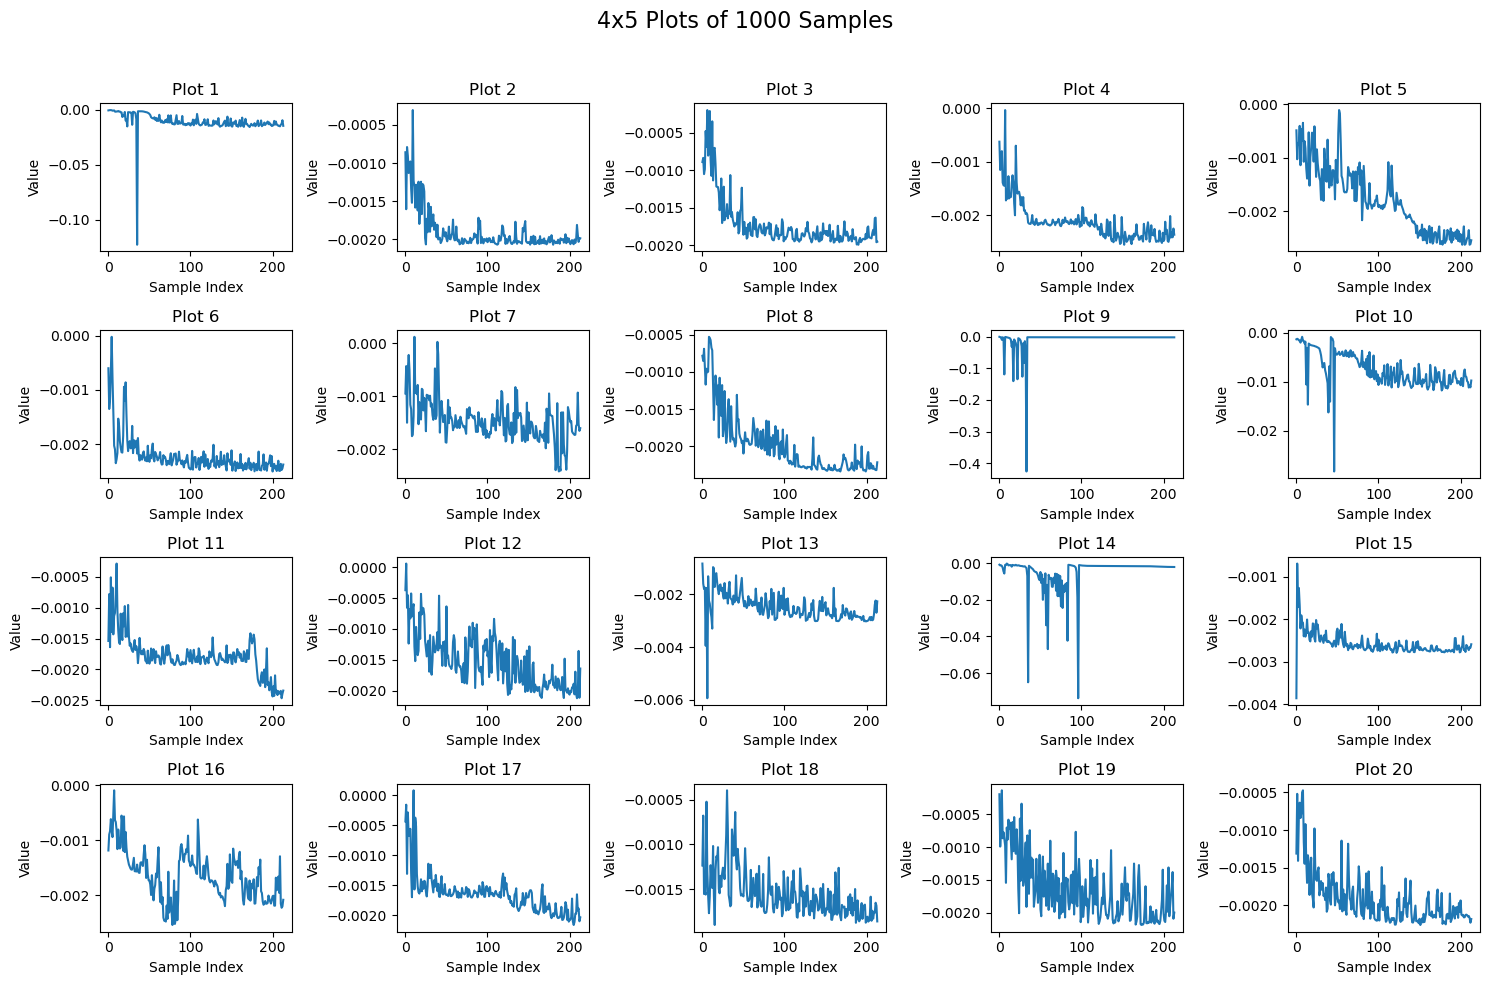

In [89]:
import numpy as np
import matplotlib.pyplot as plt
data = np.vstack(kurt_per_mu_all).T

# Generate a 20x1000 random NumPy matrix for demonstration
data = np.vstack(kurt_per_mu_all).T

# Create a 4x5 grid of subplots
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
fig.suptitle("4x5 Plots of 1000 Samples", fontsize=16)

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot each row of the matrix
for i in range(20):
    ax = axes[i]
    ax.plot(data[i])
    ax.set_title(f"Plot {i + 1}")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Value")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()


In [20]:
# Example usage:
np.random.seed(42)  # For reproducibility
S_true = emg_data.data_dict['spike_trains']


threshold_est = 0.3
threshold_true = 0.9
S_est = normalize_sources(S_est)



matches, recall_matrix,thresholds_est, thresholds_true = \
    match_estimates_to_true(S_est, S_true, threshold_est=threshold_est, threshold_true=0.9)

precision_list, recall_list, mean_precision, mean_recall = evaluate_matches(
    S_est, 
    S_true, 
    matches, 
    thresholds_est, 
    thresholds_true
)


In [22]:
matches

array([32, 85, 47, 73, 53, 31, 77, 24, 31, 86, 87, 82, 37, 31, 34, 76, 56,
       88, 43, 33])

In [23]:
recall_list

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [13]:
cond = emg_data.tensors['base_conditions'][:n_mus_search]

NameError: name 'n_mus_search' is not defined

In [14]:
import numpy as np

def create_tensor_with_grid(initial_tensor, i, j, N):
    """
    Creates an NxN,6 tensor where columns i and j contain a grid of values 
    (linspace between 0 and 1), and other columns retain values from the initial tensor.

    Parameters:
        initial_tensor (numpy.ndarray): A 1x6 tensor containing initial values.
        i (int): The index of the first column to be replaced with the grid.
        j (int): The index of the second column to be replaced with the grid.
        N (int): The size of the grid (NxN).

    Returns:
        numpy.ndarray: An NxN,6 tensor with the specified modifications.
    """
    # Create a linspace between 0 and 1 for the grid
    linspace_values = np.linspace(0, 1, N)
    grid_i, grid_j = np.meshgrid(linspace_values, linspace_values)

    # Create an NxN,6 tensor by broadcasting the initial tensor
    result_tensor = np.tile(initial_tensor, (N, N, 1))

    # Replace the i and j columns with the grid values
    result_tensor[..., i] = grid_i
    result_tensor[..., j] = grid_j

    return result_tensor

# Example usage

N = 100  # Grid size

result = create_tensor_with_grid(cond[2].cpu().numpy(), 0, 1, N)
print(result)


NameError: name 'cond' is not defined

In [15]:
from scipy.stats import qmc  # For Latin Hypercube Sampling

lhs_sampler = qmc.LatinHypercube(d=6)
    
result = torch.tensor(qmc.scale(lhs_sampler.random(10000), 0, 1), dtype=torch.float32, device='cpu')


In [16]:
result.shape

torch.Size([10000, 6])

In [10]:
#result[73,22] = [1.0000, 0.7365, 0.2257, 0.7129, 0.8192, 0.4706]

In [11]:
torch.cuda.empty_cache()

bsize = 100
total = N*N
result_batched = result.reshape(-1, bsize, 6)
all_res = []
for i in tqdm(range(result_batched.shape[0])):
    all_res.append(model.biomime_muap_gen(torch.tensor(result_batched[i]).cuda()).detach())

NameError: name 'N' is not defined

In [38]:
hmap = torch.stack(all_res)
hmap = hmap.reshape(N*N, 96, 10, 32)
hmap = hmap.reshape(N*N, 96, 320).permute(0, 2, 1).to(torch.float32)

filters = EMGProcessor.get_separation_vectors_torch(hmap, R=R)
mu1 = filters.T @  cov @ training_data
mu1.shape

torch.Size([10000, 20009])

In [48]:
from models import *

negen_loss = NegentropyLoss()
#loss = negen_loss(mu1)
loss = -torch_kurtosis(mu1)

In [49]:
loss_sorted = loss.sort()

In [58]:
loss_sorted

torch.return_types.sort(
values=tensor([-0.1542, -0.0604, -0.0591,  ...,  0.0004,  0.0005,  0.0006],
       device='cuda:0'),
indices=tensor([1948, 1560, 7157,  ..., 1376, 1647, 5783], device='cuda:0'))

In [61]:
idx = loss_sorted.indices[:20]
start_conds = result[idx.detach().cpu().numpy()]

<Axes: >

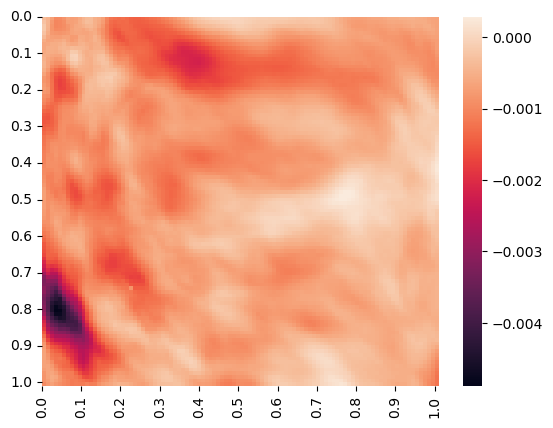

In [74]:
import seaborn as sns
import numpy as np

def heatmap_with_linspace(heatmap, N):
    """
    Creates a heatmap of the log likelihoods with custom linspace labels.

    Parameters:
        heatmap (torch.Tensor): A 1D tensor containing the log likelihood values.
        N (int): The size of the grid (NxN).

    Returns:
        seaborn.matrix.ClusterGrid: A Seaborn ClusterGrid object containing the heatmap.
    """
    # Create a Seaborn heatmap
    ax = sns.heatmap(heatmap.reshape(N, N).detach().cpu().numpy())
    
    # Set custom ticks and labels
    ticks = np.linspace(0, 1, 11)  # 0 to 1 with 0.1 intervals
    tick_labels = np.round(ticks, 1)
    
    ax.set_xticks(np.linspace(0, N-1, 11))
    ax.set_yticks(np.linspace(0, N-1, 11))
    
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    
    return ax

heatmap_with_linspace(loss, N)

In [59]:
loss.min()

tensor(-0.0018, device='cuda:0')

In [60]:
result[99, 99]

array([1.        , 0.49290782, 0.3951099 , 1.        , 0.795532  ,
       0.00884283], dtype=float32)

In [25]:
import torch
import numpy as np
from scipy.stats import qmc  # For Latin Hypercube Sampling

def compute_loss_with_batching(model, N, batch_size, R, cov, training_data):
    """
    Uses batch processing only for model evaluation, then computes the loss in numpy.

    Args:
    - model: The PyTorch model with `.biomime_muap_gen`.
    - N: Total number of points to sample in [0,1].
    - batch_size: Number of points to process per batch (only for model eval).
    - R: Some parameter required by `get_separation_vectors_torch`.
    - cov: Covariance matrix for filtering.
    - training_data: Training data tensor.

    Returns:
    - loss_per_mu: NumPy array of shape (N,), loss values per condition.
    - sampled_conds: NumPy array of shape (N, 6), the sampled conditions.
    """
    device = next(model.parameters()).device  # Ensure same device as model

    # 1. Generate Latin Hypercube Sampled points in [0,1] of shape (N,6)
    lhs_sampler = qmc.LatinHypercube(d=6)
    lhs_samples = torch.tensor(qmc.scale(lhs_sampler.random(N), 0, 1), dtype=torch.float32, device=device)

    num_batches = (N + batch_size - 1) // batch_size  # Compute number of batches
    all_muaps = []

    # 2. Evaluate model in batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, N)
        current_batch_size = end_idx - start_idx

        # Extract batch of conditions
        conds_batch = lhs_samples[start_idx:end_idx]

        # Forward pass through model
        muaps = model(conds_batch)
        muaps = muaps.reshape(current_batch_size, 96, 320).permute(0, 2, 1).to(torch.float32)

        # Store results in list (avoid keeping PyTorch graph)
        all_muaps.append(muaps.detach().cpu().numpy())

    # 3. Stack all muaps into a single NumPy array
    all_muaps = np.concatenate(all_muaps, axis=0)  # Shape (N, 320, 96)

    # 4. Compute filters in NumPy
    filters = EMGProcessor.get_separation_vectors_numpy(all_muaps, R=R)  # Assume a NumPy equivalent function

    # 5. Compute response in NumPy
    cov_np = cov.cpu().numpy()
    training_data_np = training_data.cpu().numpy()
    mu1 = np.einsum('ij,jk,kl->il', filters.T, cov_np, training_data_np)  # Shape (N, time_points)

    # 6. Compute kurtosis for each mu
    loss_per_mu = -scipy.stats.kurtosis(mu1, axis=1)  # Shape (N,)

    return loss_per_mu, lhs_samples.cpu().numpy()  # Return loss per condition and sampled conditions


In [26]:
torch.cuda.empty_cache()

In [24]:
N = 10000  # Total points to sample
batch_size = 100  # Number of points per batch
R = 10  # Some parameter

loss, conds_used = compute_loss_with_batching(model.biomime_muap_gen, N, batch_size, R, cov, training_data)
print(f"Total Loss: {loss}")
print(f"Sampled Conditions Shape: {conds_used.shape}")  # Should be (N,6)


  5%|▌         | 5/100 [00:19<06:07,  3.87s/it]


KeyboardInterrupt: 